<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.06/analysis_by_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/deadsnak

In [62]:
# Download a Postgres driver that will allow Spark to interact with Postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-09-08 00:42:52--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.2’

postgresql-42.2.16. 100%[===================>] 979.38K  5.01MB/s    in 0.2s    

2022-09-08 00:42:53 (5.01 MB/s) - ‘postgresql-42.2.16.jar.2’ saved [1002883/1002883]



In [63]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [64]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/sentiment_joined_events_twitter_post_ml.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("sentiment_joined_events_twitter_post_ml.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|_c0|       username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|is_retweet|is_quote_status|extractedts|weekofyear|date_published|search_result| weight|        cleaned_text|            negative|             neutral|            positive|
+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|  0|      WashTimes|   1893.0| 417389.0|   335685.0|   2008-05-

In [65]:
# Convert DataFrame to Pandas
tweets_df = text_df.toPandas()
print(tweets_df.shape)
tweets_df.head(5)

(713009, 22)


,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,democrats urge biden to counter pain at pump w...,0.222473,0.747085,0.030443
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,now is the time to annex cuba just sayin,0.078324,0.799905,0.121771
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,please take care,0.063437,0.643451,0.293113


In [66]:
# Check data types
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713009 entries, 0 to 713008
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _c0              713009 non-null  int32  
 1   username         713008 non-null  object 
 2   following        713008 non-null  float64
 3   followers        713008 non-null  float64
 4   totaltweets      713008 non-null  float64
 5   usercreatedts    713008 non-null  object 
 6   tweetcreatedts   713008 non-null  object 
 7   retweetcount     713008 non-null  float64
 8   hashtags         713008 non-null  object 
 9   language         713008 non-null  object 
 10  favorite_count   713008 non-null  float64
 11  is_retweet       344456 non-null  object 
 12  is_quote_status  344456 non-null  object 
 13  extractedts      713008 non-null  object 
 14  weekofyear       713008 non-null  float64
 15  date_published   710367 non-null  object 
 16  search_result    710367 non-null  floa

In [67]:
# Change the dtypes of usercreatedts, tweetcreatedts, and extractedts to datetime64 for easier operation later
tweets_df["usercreatedts"] = pd.to_datetime(tweets_df["usercreatedts"])
tweets_df["tweetcreatedts"] = pd.to_datetime(tweets_df["tweetcreatedts"])
tweets_df["extractedts"] = pd.to_datetime(tweets_df["extractedts"])
tweets_df["date_published"] = pd.to_datetime(tweets_df["date_published"])

# Change object type to boolean for columns 'is_retweet' and 'is_quote_status'
tweets_df["is_retweet"] = tweets_df['is_retweet'].astype(bool)
tweets_df["is_quote_status"] = tweets_df['is_quote_status'].astype(bool)

# check dtypes
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713009 entries, 0 to 713008
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   _c0              713009 non-null  int32         
 1   username         713008 non-null  object        
 2   following        713008 non-null  float64       
 3   followers        713008 non-null  float64       
 4   totaltweets      713008 non-null  float64       
 5   usercreatedts    713008 non-null  datetime64[ns]
 6   tweetcreatedts   713008 non-null  datetime64[ns]
 7   retweetcount     713008 non-null  float64       
 8   hashtags         713008 non-null  object        
 9   language         713008 non-null  object        
 10  favorite_count   713008 non-null  float64       
 11  is_retweet       713009 non-null  bool          
 12  is_quote_status  713009 non-null  bool          
 13  extractedts      713008 non-null  datetime64[ns]
 14  weekofyear       713

In [68]:
# When were the earliest and latest tweets in this dataset created
earliest_tweet = tweets_df["tweetcreatedts"].min()
latest_tweet = tweets_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-02-24 00:00:00, and the latest was at 2022-08-18 00:00:00


In [69]:
# get dates in the dataframe 
#dates = tweets_df["tweetcreatedts"].dt.day
dates = tweets_df["tweetcreatedts"].dt.date
dates


0         2022-02-26
1         2022-02-26
2         2022-02-26
3         2022-02-26
4         2022-02-26
             ...    
713004    2022-02-26
713005    2022-02-26
713006    2022-02-26
713007    2022-02-26
713008           NaT
Name: tweetcreatedts, Length: 713009, dtype: object

There are NaT values in the time column 'tweetcreatedts', and we should get rid of it before we can analyse dataframe. 

In [70]:
tweets_df.shape

(713009, 22)

In [71]:
# drop all rows with any NaT values in the tweetcreatedts column
tweets_df = tweets_df.dropna(axis=0, subset=['tweetcreatedts'])


In [84]:
#Check the null values
for column in tweets_df.columns:
    print(f'Column {column} has {tweets_df[column].isnull().sum()} null values')

Column _c0 has 0 null values
Column username has 0 null values
Column following has 0 null values
Column followers has 0 null values
Column totaltweets has 0 null values
Column usercreatedts has 0 null values
Column tweetcreatedts has 0 null values
Column retweetcount has 0 null values
Column hashtags has 0 null values
Column language has 0 null values
Column favorite_count has 0 null values
Column is_retweet has 0 null values
Column is_quote_status has 0 null values
Column extractedts has 0 null values
Column weekofyear has 0 null values
Column date_published has 2642 null values
Column search_result has 2642 null values
Column weight has 2642 null values
Column cleaned_text has 11 null values
Column negative has 0 null values
Column neutral has 0 null values
Column positive has 0 null values


There are 2642 null values in the news columns: 
date_published
search_result
weight
It is because twitter dataset till August 18, and news dataset till August 12 only. We can drop the data from August 12 till 18.

In [85]:
tweets_df = tweets_df.dropna()
tweets_df.shape

(710355, 22)

In [86]:
# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = tweets_df["tweetcreatedts"].groupby(dates).size()
max = tweets_df["tweetcreatedts"].groupby(dates).size().max
tweetcount_by_date.head(50)


tweetcreatedts
2022-02-24     2459
2022-02-25     4635
2022-02-26     5821
2022-02-27     6814
2022-02-28     5392
2022-03-01     5819
2022-03-02     5937
2022-03-03     5612
2022-03-04     6955
2022-03-05     8328
2022-03-06     9071
2022-03-07    10012
2022-03-08     8847
2022-03-09     7860
2022-03-10     7675
2022-03-11     7161
2022-03-12     6725
2022-03-13     7331
2022-03-14     7096
2022-03-15     8468
2022-03-16     7688
2022-03-17     8245
2022-03-18     8291
2022-03-19     7137
2022-03-20     7180
2022-03-21     8494
2022-03-22     6880
2022-03-23     6852
2022-03-24     6413
2022-03-25     7250
2022-03-26     6930
2022-03-27     5930
2022-03-28     6301
2022-03-29     5777
2022-03-30     5354
2022-03-31     5401
2022-04-01     6199
2022-04-02     6311
2022-04-03     7127
2022-04-04     6445
2022-04-05     6502
2022-04-06     6420
2022-04-07     5664
2022-04-08     5587
2022-04-09     5899
2022-04-10     5637
2022-04-11     5531
2022-04-12     5654
2022-04-13     5658
2022-

In [87]:
tweetcount_by_date.tail(50)

tweetcreatedts
2022-06-24    2671
2022-06-25    2182
2022-06-26    2832
2022-06-27    3130
2022-06-28    3302
2022-06-29    2777
2022-06-30    2538
2022-07-01    2465
2022-07-02    2007
2022-07-03    1957
2022-07-04    2519
2022-07-05    2437
2022-07-06    2498
2022-07-07    2524
2022-07-08    2303
2022-07-09    1924
2022-07-10    2073
2022-07-11    2902
2022-07-12    2456
2022-07-13    2239
2022-07-14    3073
2022-07-15    2621
2022-07-16    1846
2022-07-17    2082
2022-07-18    2202
2022-07-19    2148
2022-07-20    2367
2022-07-21    1637
2022-07-22    1577
2022-07-23    1591
2022-07-24    1312
2022-07-25    1357
2022-07-26    1374
2022-07-27    1605
2022-07-28    1792
2022-07-29    2265
2022-07-30    1694
2022-07-31    1670
2022-08-01    1982
2022-08-02    2671
2022-08-03    2171
2022-08-04    1920
2022-08-05    1770
2022-08-06    2068
2022-08-07    2040
2022-08-08     706
2022-08-09     373
2022-08-10     670
2022-08-11     596
2022-08-12    1124
Name: tweetcreatedts, dtype: int64

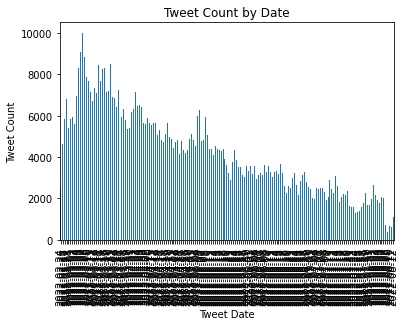

In [88]:
# Visualize tweet counts by date

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=90)
plt.show()

In [89]:
# Change the negative score to negative value
tweets_df["negative"] = -1.0*tweets_df["negative"]
tweets_df.head(5)

,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,democrats urge biden to counter pain at pump w...,0.222473,0.747085,0.030443
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,now is the time to annex cuba just sayin,0.078324,0.799905,0.121771
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,please take care,0.063437,0.643451,0.293113


In [90]:
# Extract negative score of twits and time, when they were created
negative_tweets_df = tweets_df[['tweetcreatedts', 'negative']]
negative_tweets_df.head(5)

,tweetcreatedts,negative
0,2022-02-26,0.222473
1,2022-02-26,0.078324
2,2022-02-26,0.147500
3,2022-02-26,0.883955
4,2022-02-26,0.063437


In [91]:
# get dates in the dataframe 
dates = negative_tweets_df["tweetcreatedts"].dt.date
dates

0         2022-02-26
1         2022-02-26
2         2022-02-26
3         2022-02-26
4         2022-02-26
             ...    
713003    2022-02-26
713004    2022-02-26
713005    2022-02-26
713006    2022-02-26
713007    2022-02-26
Name: tweetcreatedts, Length: 710355, dtype: object

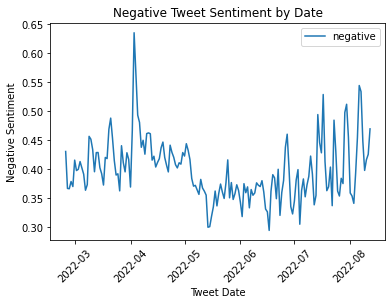

In [92]:
# Visualize negative tweet sentiment by date

# group tweet timestamps by date and get mean negative score for each date
negative_by_date =  negative_tweets_df.groupby([negative_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet negative sentiment by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiment by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [93]:
# Extract positive score of twits and time, when they were created
positive_tweets_df = tweets_df[['tweetcreatedts', 'positive']]
positive_tweets_df.head(5)

,tweetcreatedts,positive
0,2022-02-26,0.030443
1,2022-02-26,0.121771
2,2022-02-26,0.028057
3,2022-02-26,0.006116
4,2022-02-26,0.293113


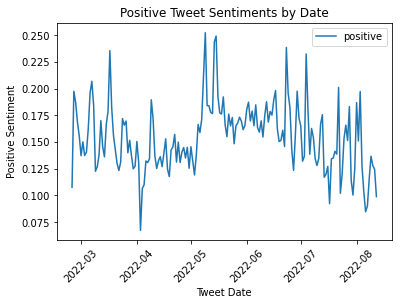

In [94]:
# Visualize positive tweet sentiment by date
# get dates in the dataframe 
dates = positive_tweets_df["tweetcreatedts"].dt.date
# group tweet timestamps by date and get mean positive score for each date
positive_by_date =  positive_tweets_df.groupby([positive_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_by_date.plot.line();

plt.title("Positive Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

# Analysis for Ukraine - Russia comparison


In [95]:
# Analysis for Ukraine word
ukraine_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
ukraine_df.head(5)

,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
7,7,kimvais,706.0,262.0,5145.0,2008-04-25,2022-02-26,78.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,since finnish politicians apparently still are...,0.116559,0.831112,0.052329
13,13,mistergrainger,732.0,355.0,1925.0,2008-04-28,2022-02-26,131.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,pr agency friends the people of ukraine are de...,0.178426,0.655819,0.165756
24,24,edbott,2484.0,53410.0,226086.0,2008-01-14,2022-02-26,7546.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,to the free people of the world we feel your s...,0.059624,0.392598,0.547778
25,25,truthwsyf,132.0,49.0,6851.0,2008-08-05,2022-02-26,125.0,"[{'text': 'UkraineRussiaWar', 'indices': [21, ...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,which country do you stand with like for ukrai...,0.097028,0.879737,0.023235


In [96]:
# Extract negative score of twits and time, when they were created
negative_for_ukraine = ukraine_df[['tweetcreatedts', 'negative']]
negative_for_ukraine.head(5)

,tweetcreatedts,negative
2,2022-02-26,0.147500
7,2022-02-26,0.116559
13,2022-02-26,0.178426
24,2022-02-26,0.059624
25,2022-02-26,0.097028


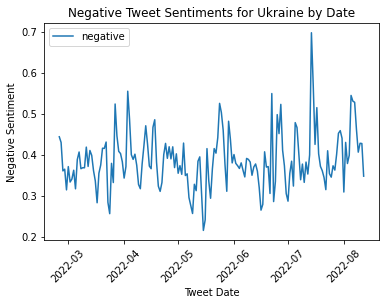

In [97]:
# Visualize tweet negative sentiment for Ukraine by date
# get dates in the dataframe 
dates = negative_for_ukraine["tweetcreatedts"].dt.date
# group tweet timestamps by date and get mean negative score for each date
negative_ukraine_by_date =  negative_for_ukraine.groupby([negative_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_ukraine_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [98]:
# Extract positive score of twits and time, when they were created
positive_for_ukraine = ukraine_df[['tweetcreatedts', 'positive']]
positive_for_ukraine.head(5)

,tweetcreatedts,positive
2,2022-02-26,0.028057
7,2022-02-26,0.052329
13,2022-02-26,0.165756
24,2022-02-26,0.547778
25,2022-02-26,0.023235


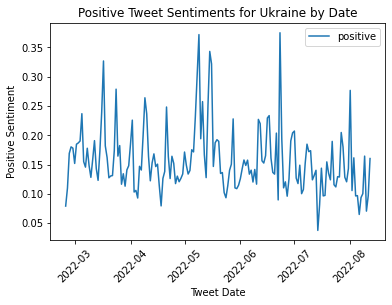

In [99]:
# Visualize tweet positive sentiment for Ukraine by date
# get dates in the dataframe 
dates = positive_for_ukraine["tweetcreatedts"].dt.date
# group tweet timestamps by date and get mean positive score for each date
positive_ukraine_by_date =  positive_for_ukraine.groupby([positive_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_ukraine_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [100]:
# Analysis for Russia word
russia_df = tweets_df[tweets_df['cleaned_text'].str.contains('russia')]
russia_df.head(5)

,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
6,6,catmuir,772.0,161.0,4843.0,2006-12-06,2022-02-26,2407.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,faith in humanity on a very dark day for the w...,0.002919,0.033193,0.963888
16,16,firejack007,1085.0,520.0,56005.0,2008-09-24,2022-02-26,6.0,"[{'text': 'BREAKING', 'indices': [20, 29]}]",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,mariupol is being surrounded right now russia...,0.666204,0.326554,0.007242
19,19,proudmari,1834.0,517.0,20397.0,2008-03-20,2022-02-26,8996.0,"[{'text': 'Ukraine', 'indices': [117, 125]}]",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,russian state tv channels have been hacked and...,0.660646,0.329659,0.009694
21,21,BradParker_,2087.0,2638.0,359083.0,2008-08-18,2022-02-26,1484.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,so proud of my little island our liquor stores...,0.002038,0.012186,0.985776


In [101]:
# Extract negative score for Russia of twits and time, when they were created
negative_for_russia = russia_df[['tweetcreatedts', 'negative']]
negative_for_russia.head(5)

,tweetcreatedts,negative
3,2022-02-26,0.883955
6,2022-02-26,0.002919
16,2022-02-26,0.666204
19,2022-02-26,0.660646
21,2022-02-26,0.002038


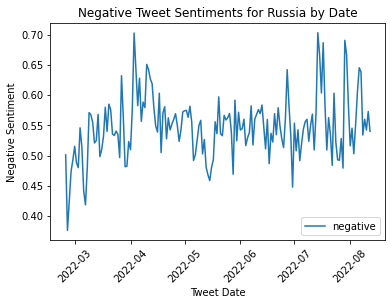

In [102]:
# Visualize negative tweet sentiment for Rossia by date
# get dates in the dataframe 
dates = negative_for_russia["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
negative_russia_by_date =  negative_for_russia.groupby([negative_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_russia_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Russia by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [103]:
# Extract positive score of twits for Russia and time, when they were created
positive_for_russia = russia_df[['tweetcreatedts', 'positive']]
positive_for_russia.head(5)

,tweetcreatedts,positive
3,2022-02-26,0.006116
6,2022-02-26,0.963888
16,2022-02-26,0.007242
19,2022-02-26,0.009694
21,2022-02-26,0.985776


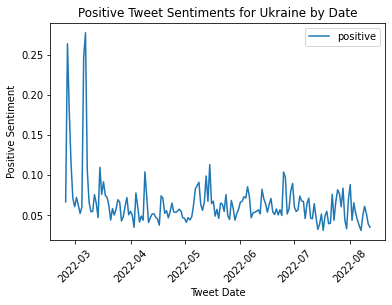

In [104]:
# Visualize tweet positive sentiment for Russia by date
# get dates in the dataframe 
dates = positive_for_russia["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average positive score for each date
positive_russia_by_date =  positive_for_russia.groupby([positive_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_russia_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

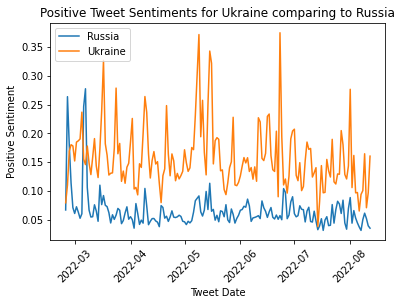

In [105]:
# The plot for Ukraine and Russia positive together
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_russia_by_date['positive'], label ='Russia')
ax.plot(positive_ukraine_by_date['positive'], label ='Ukraine')
plt.legend(loc="upper left")
plt.show()


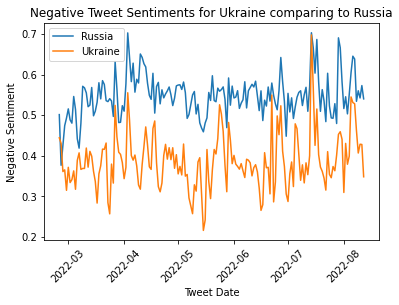

In [106]:
# The plot for Ukraine and Russia negative together
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_russia_by_date['negative'], label ='Russia')
ax.plot(negative_ukraine_by_date['negative'], label ='Ukraine')
plt.legend(loc="upper left")
plt.show()

# Analysis for Zelensky - Putin comparison

In [107]:
# Analysis for Zelensky word
zelensky_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
zelensky_df.head(5)

,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
7,7,kimvais,706.0,262.0,5145.0,2008-04-25,2022-02-26,78.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,since finnish politicians apparently still are...,0.116559,0.831112,0.052329
13,13,mistergrainger,732.0,355.0,1925.0,2008-04-28,2022-02-26,131.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,pr agency friends the people of ukraine are de...,0.178426,0.655819,0.165756
24,24,edbott,2484.0,53410.0,226086.0,2008-01-14,2022-02-26,7546.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,to the free people of the world we feel your s...,0.059624,0.392598,0.547778
25,25,truthwsyf,132.0,49.0,6851.0,2008-08-05,2022-02-26,125.0,"[{'text': 'UkraineRussiaWar', 'indices': [21, ...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,which country do you stand with like for ukrai...,0.097028,0.879737,0.023235


In [108]:
# Extract negative score for Zelensky of twits and time, when they were created
negative_for_zelensky = zelensky_df[['tweetcreatedts', 'negative']]
negative_for_zelensky.head(5)

,tweetcreatedts,negative
2,2022-02-26,0.147500
7,2022-02-26,0.116559
13,2022-02-26,0.178426
24,2022-02-26,0.059624
25,2022-02-26,0.097028


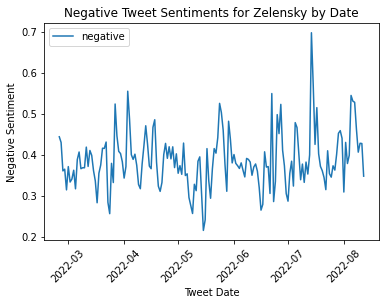

In [109]:
# Visualize negative tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = negative_for_zelensky["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
negative_zelensky_by_date =  negative_for_zelensky.groupby([negative_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_zelensky_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [110]:
# Extract positive score for Zelensky of twits and time, when they were created
positive_for_zelensky = zelensky_df[['tweetcreatedts', 'positive']]
positive_for_zelensky.head(5)

,tweetcreatedts,positive
2,2022-02-26,0.028057
7,2022-02-26,0.052329
13,2022-02-26,0.165756
24,2022-02-26,0.547778
25,2022-02-26,0.023235


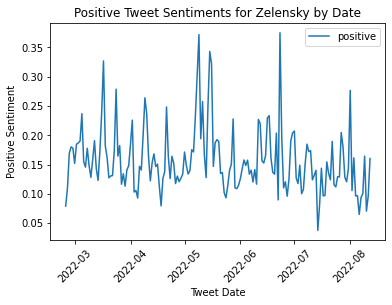

In [112]:
# Visualize positive tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = positive_for_zelensky["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
positive_zelensky_by_date =  positive_for_zelensky.groupby([positive_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_zelensky_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [113]:
# Analysis for Putin word
putin_df = tweets_df[tweets_df['cleaned_text'].str.contains('putin')]
putin_df.head(5)

,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
27,27,jeneroux,1295.0,7785.0,5046.0,2008-08-11,2022-02-26,130.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,it is time to get serious about threats from r...,0.428227,0.538401,0.033372
41,41,dsimon22,4388.0,1220.0,44092.0,2008-06-26,2022-02-26,891.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
44,44,doubtofbuddha,368.0,98.0,2752.0,2007-12-11,2022-02-26,84.0,"[{'text': 'Ukraine', 'indices': [40, 48]}]",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,iranians gather in front of embassy in tehran ...,0.677831,0.314766,0.007403
59,59,teppdude,2854.0,3946.0,525291.0,2008-11-15,2022-02-28,73.0,"[{'text': 'warcrimes', 'indices': [41, 51]}, {...",en,...,False,2022-02-28,9.0,2022-02-28,142000.0,0.000714,my latest for putins are well documentedin el...,0.830981,0.163272,0.005747


In [114]:
# Extract negative score for Putin of twits and time, when they were created
negative_for_putin = putin_df[['tweetcreatedts', 'negative']]
negative_for_putin.head(5)

,tweetcreatedts,negative
3,2022-02-26,0.883955
27,2022-02-26,0.428227
41,2022-02-26,0.883955
44,2022-02-26,0.677831
59,2022-02-28,0.830981


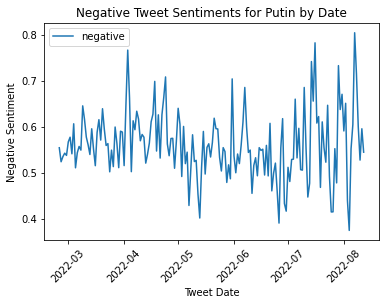

In [115]:
# Visualize negative tweet sentiment for Putin by date
# get dates in the dataframe 
dates = negative_for_putin["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
negative_putin_by_date =  negative_for_putin.groupby([negative_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_putin_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [116]:
# Extract positive score for Putin of twits and time, when they were created
positive_for_putin = putin_df[['tweetcreatedts', 'positive']]
positive_for_putin.head(5)

,tweetcreatedts,positive
3,2022-02-26,0.006116
27,2022-02-26,0.033372
41,2022-02-26,0.006116
44,2022-02-26,0.007403
59,2022-02-28,0.005747


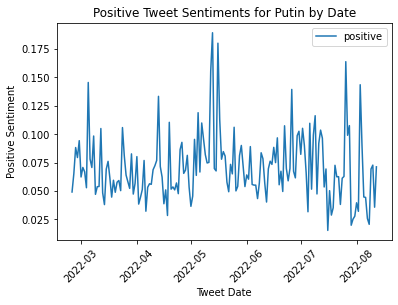

In [117]:
# Visualize positive tweet sentiment for Putin by date
# get dates in the dataframe 
dates = positive_for_putin["tweetcreatedts"].dt.date
# group tweet timestamps by date and get average negative score for each date
positive_putin_by_date =  positive_for_putin.groupby([positive_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_putin_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

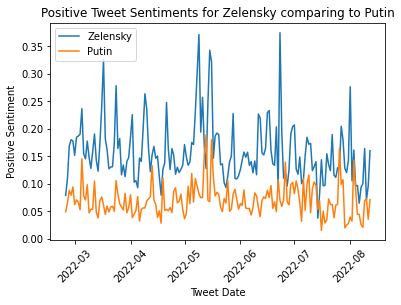

In [118]:
# The plot comparing positive score for Zelensky and Putin
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_zelensky_by_date['positive'], label='Zelensky')
ax.plot(positive_putin_by_date['positive'], label='Putin')
plt.legend(loc="upper left")
plt.show()

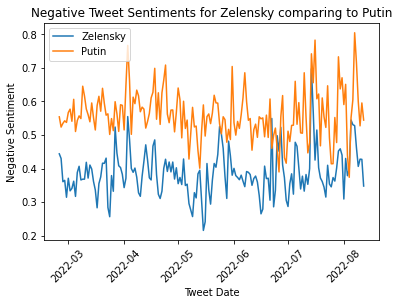

In [119]:
# The plot comparing negative score for Zelensky and Putin
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_zelensky_by_date['negative'], label='Zelensky')
ax.plot(negative_putin_by_date['negative'], label='Putin')
plt.legend(loc="upper left")
plt.show()